# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

You should consider upgrading via the '/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/bin/python3 -m pip install --upgrade pip' command.


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

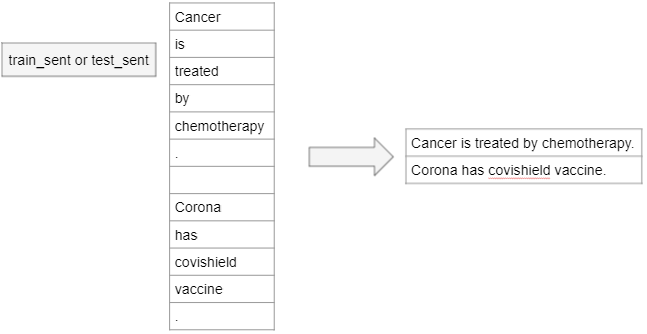

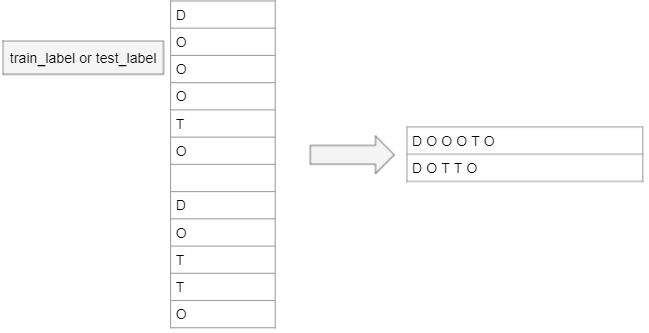

In [2]:
# Function to read content from a file, construct and return sentences
def getContentFromFile(file, ):
    with open(file, 'r') as sent_file:
        content = sent_file.readlines()

    print(f"{file:15}: length: {len(content):5d} Samples: {content[0].strip():13} {content[10].strip():10}")

    sentences = []
    sent = ""
    for word in content:
        word = word.strip()
        if word == "":
            sentences.append(sent.strip())
            sent = ""
            continue

        sent = f"{sent} {word.strip()}"
 
    return sentences

In [3]:
# Read train & test sentences and labels
train_sentences = getContentFromFile('train_sent')
test_sentences  = getContentFromFile('test_sent')
train_labels = getContentFromFile('train_label')
test_labels  = getContentFromFile('test_label')

train_sent     : length: 48501 Samples: All           University
test_sent      : length: 19674 Samples: Furthermore   risk      
train_label    : length: 48501 Samples: O             O         
test_label     : length: 19674 Samples: O             O         


In [4]:
# Print 5 sample sentences
print("5 sample sentences from the train dataset:")
[print(i+6, train_sentences[5:10][i]) for i in range(len(train_sentences[6:10]))];print()

5 sample sentences from the train dataset:
6 Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age
7 In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid status
8 We hypothesize that as temperature increases there would be a concomitant decrease in AFI
9 From June 11 to August 16 , 1993 , during a period of unusual high heat , 42 women with singleton pregnancies between 27 and 40 weeks ' gestation undergoing serial antenatal testing had AFI determinations recorded at least weekly



### Count the number of sentences in the processed train and test dataset 

In [5]:
print(f"Number of sentences in TRAIN dataset: {len(train_sentences)}\nSamples:\n\t1. {train_sentences[0]}\n\t2. {train_sentences[1]}");print()
print(f"Number of sentences in TEST dataset: {len(test_sentences)}\nSamples:\n\t1. {test_sentences[0]}\n\t2. {test_sentences[1]}")

Number of sentences in TRAIN dataset: 2599
Samples:
	1. All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
	2. The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

Number of sentences in TEST dataset: 1056
Samples:
	1. Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
	2. As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
print(f"Number of labels in TRAIN dataset: {len(train_labels)}\nSamples:\n\t1. {train_labels[0]}\n\t2. {train_labels[1]}");print()
print(f"Number of labels in TEST dataset: {len(test_labels)}\nSamples:\n\t1. {test_labels[0]}\n\t2. {test_labels[1]}")

Number of labels in TRAIN dataset: 2599
Samples:
	1. O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
	2. O O O O O O O O O O O O O O O O O O O O O O O O O

Number of labels in TEST dataset: 1056
Samples:
	1. O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
	2. O O O O O O O O O O O O O O O O O O O


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [7]:
# For each sentence in the train and test datasets, get the PoS tags. 
# If the PoS tags are either NOUN or PROPN, add them to a dictionary and count the number of times they occur.
# Sort the dictionary based on the count values
tokens_noun = {}
for sent in train_sentences + test_sentences:#[0:10]:
    processed_doc = model(sent); #process input and perform NLP tasks
    for word in processed_doc:
        #print(word.text, word.pos_)
        if word.pos_ in ['NOUN', 'PROPN']:
            if word.text in tokens_noun.keys():
                tokens_noun[word.text] += 1
            else:  
                tokens_noun[word.text] = 1

tokens_noun = sorted(tokens_noun.items(), key=lambda kv: kv[1], reverse=True)
len(tokens_noun)#, tokens_noun

6442

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [8]:
tokens_noun[:25]

[('patients', 492),
 ('treatment', 281),
 ('%', 247),
 ('cancer', 200),
 ('therapy', 175),
 ('study', 153),
 ('disease', 142),
 ('cell', 140),
 ('lung', 116),
 ('group', 94),
 ('chemotherapy', 88),
 ('gene', 87),
 ('effects', 85),
 ('results', 78),
 ('women', 77),
 ('TO_SEE', 75),
 ('use', 74),
 ('risk', 71),
 ('cases', 71),
 ('surgery', 71),
 ('analysis', 70),
 ('rate', 67),
 ('dose', 66),
 ('response', 66),
 ('survival', 65)]

The top 25 frequently occurring words contain words like 
- disease --> These are related to disease
- treatment, therapy, chemotherapy, surgery, dose --> These are related to treatment 

We could perhaps use these as features

## Defining features for CRF





In [9]:
# Utility Functions
import regex as re
PATTERN_DISEASE = 'D+'
PATTERN_TREATMENT = 'T+'

# Function to get the PoS of the words in the sentence
def getPOS(sent):
    processed_doc = model(sent)
    pos_string = ' '.join([word.pos_ for word in processed_doc])
    #print(pos_string)
    return pos_string

# Function to get the disease and treatment from a sentence by looking for the occrrence of Ds & Ts
def searchForPattern(pattern, sent, string):
    result = re.search(pattern, string)
    start_ = result.start(); last_ = result.end()
    match_string = ' '.join(sent[start_:last_])
    print(f"{start_:2}, {last_:2}, {result.group():20}, {match_string}")
    return start_, last_, match_string

def getDiseaseAndTreatment(sent, label):
    label = label.replace(' ','')
    pos_string = getPOS(sent)
    #print(pos_string)
    sent = sent.split()

    start_d, last_d, disease = searchForPattern(PATTERN_DISEASE, sent, label)
    print(' '.join(pos_string.split()[start_d:last_d]))

    start_t, last_t, treatment = searchForPattern(PATTERN_TREATMENT, sent, label)
    print(' '.join(pos_string.split()[start_t:last_t]))

    return disease, treatment

# Gets the disease and treatment from a sentence
# max specifies how many sentences to process. Byt default 100000 sentences are processed
def getDTFromSentence(sentences, labels, max=100000):
    count = 0
    D2T = {}
    for i in range(len(labels)):
        sent = sentences[i]
        label = labels[i]
        '''if 'retinoblastoma' in sent:
            print(f"\n{i}");print(sent)'''
        if 'D' in label and 'T' in label:
            #print(f"\nSentence: {i}");print(sent)
            disease, treatment = getDiseaseAndTreatment(sent, label)
            D2T[disease] = treatment

            count += 1
            if count >= max: break  
            
    print(f"**{i} {count}**")
    return D2T 

In [10]:
# Check the working of the function for 5 sentences in the TRAIN dataset
print("TRAIN dataset - disease and treatment")
getDTFromSentence(train_sentences, train_labels, max=5)

TRAIN dataset - disease and treatment
 8, 14, DDDDDD              , macrosomic infants in gestational diabetes cases
ADJ NOUN ADP ADJ NOUN NOUN
15, 18, TTT                 , good glycemic control
ADJ ADJ NOUN
17, 19, DD                  , large meningomyelocele
ADJ ADP
 8, 10, TT                  , corrective surgery
ADP ADJ
14, 16, DD                  , subsequent cancers
ADJ NOUN
25, 27, TT                  , radiation treatment
NOUN NOUN
17, 18, D                   , epilepsy
NOUN
 9, 10, T                   , methylphenidate
NOUN
12, 19, DDDDDDD             , cardiovascular morbidity and mortality after myocardial infarction
ADJ NOUN CCONJ NOUN ADP ADJ NOUN
 2, 11, TTTTTTTTT           , Antiplatelet therapy with aspirin and systematic anticoagulation with warfarin
VERB NOUN ADP NOUN CCONJ ADJ NOUN ADP NOUN
**156 5**


{'macrosomic infants in gestational diabetes cases': 'good glycemic control',
 'large meningomyelocele': 'corrective surgery',
 'subsequent cancers': 'radiation treatment',
 'epilepsy': 'methylphenidate',
 'cardiovascular morbidity and mortality after myocardial infarction': 'Antiplatelet therapy with aspirin and systematic anticoagulation with warfarin'}

In [11]:
# Check the working of the getDTFromSentence function for 5 sentences in the TRAIN dataset
print("TEST dataset - disease and treatment")
getDTFromSentence(test_sentences, test_labels, max=5)

TEST dataset - disease and treatment
 9, 10, D                   , epilepsy
NOUN
 2,  3, T                   , Methylphenidate
PROPN
12, 14, DD                  , myocardial infarction
ADJ NOUN
17, 20, TTT                 , 160 mg aspirin
NUM PROPN PROPN
27, 29, DD                  , unstable angina
NOUN NOUN
 5,  6, T                   , roxithromycin
PROPN
18, 20, DD                  , coronary-artery disease
ADJ PUNCT
 2,  4, TT                  , Antichlamydial antibiotics
ADJ NOUN
12, 16, DDDD                , myofascial trigger point pain
ADJ NOUN NOUN NOUN
 4,  5, T                   , ENS
PROPN
**105 5**


{'epilepsy': 'Methylphenidate',
 'myocardial infarction': '160 mg aspirin',
 'unstable angina': 'roxithromycin',
 'coronary-artery disease': 'Antichlamydial antibiotics',
 'myofascial trigger point pain': 'ENS'}

In [12]:
# Get features from a word
VOCAB_TREATMENT = ['treatment', 'therapy', 'surgery','dose','chemotherapy', 'mg'] # top occurring words related to treatment
VOCAB_DISEASE   = ['disease','infection', 'syndrome','acute', 'nsclc','ii','iii'] # top occurring words related to disease

def getFeaturesForAWord(sentence, POS_words, pos):
    word = sentence[pos]
    word_l = word.lower()
    POS = POS_words[pos]
    features = {
        'word.treatment'    : word_l in VOCAB_TREATMENT,
        'word.disease'      : word_l in VOCAB_DISEASE, 
        'word.lower'        : word_l, 
        'word.pos'          : POS,     
        'word[-7:]'         : word_l[-7:], # therapy
        'word[-6:]'         : word_l[-6:], # ectomy, platin
        'word[-4:]'         : word_l[-4:], # itis, 
        'word[-3:]'         : word_l[-3:],
        'word[-2:]'         : word_l[-2:],   
        'word.isupper'      : word.isupper(),
        'word.isidigt'      : word.isdigit(),
        'words.startsWithCapital' : word[0].isupper()
    }

    if pos == 0:
        features.update({'BEG' : True})
    else:
        prev_word = sentence[pos-1]
        prev_POS = POS_words[pos-1]
        features.update({
            'prev_words.lower'      : prev_word.lower(),
            'prev_word.pos'         : prev_POS,  
            'prev_words.isupper'    : prev_word.isupper(),
            'prev_words.isdigit'    : prev_word.isdigit(), 
            'prev_words.startsWithCapital' : prev_word[0].isupper()})

    if pos == len(sentence)-1:
        features.update({'END' : True})

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [13]:
# Function to get features for a sentence.
def getFeaturesForASentence(sentence):
    sentence_words = sentence.split()
    POS_words = getPOS(sentence).split()
    return [getFeaturesForAWord(sentence_words, POS_words, pos) for pos in range(len(sentence_words))]

### Write a code/function to get the labels of a sentence

In [14]:
# Function to get the labels for a sentence.
def getLabelsForASentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [15]:
# Try the sentencen split and get features on a sample sentence
sample = train_sentences[5]
print(f"Sample sentence: {len(sample.split())}, {sample}");print()

features = getFeaturesForASentence(sample)
print("Word & features")
[print(f"{i}: {features[i]}") for i in range(len(features))];print()

Sample sentence: 24, Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age

Word & features
0: {'word.treatment': False, 'word.disease': False, 'word.lower': 'cesarean', 'word.pos': 'ADJ', 'word[-7:]': 'esarean', 'word[-6:]': 'sarean', 'word[-4:]': 'rean', 'word[-3:]': 'ean', 'word[-2:]': 'an', 'word.isupper': False, 'word.isidigt': False, 'words.startsWithCapital': True, 'BEG': True}
1: {'word.treatment': False, 'word.disease': False, 'word.lower': 'rates', 'word.pos': 'NOUN', 'word[-7:]': 'rates', 'word[-6:]': 'rates', 'word[-4:]': 'ates', 'word[-3:]': 'tes', 'word[-2:]': 'es', 'word.isupper': False, 'word.isidigt': False, 'words.startsWithCapital': False, 'prev_words.lower': 'cesarean', 'prev_word.pos': 'ADJ', 'prev_words.isupper': False, 'prev_words.isdigit': False, 'prev_words.startsWithCapital': True}
2: {'word.treatment': False, 'word.disease': False, 'word.lower': 'at

In [16]:
# Get features and labels for the sentences in the train dataset
type(train_sentences), len(train_sentences)
X_train = [getFeaturesForASentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsForASentence(labels) for labels in train_labels]

In [17]:
# check features and labels for a sample sentence
[print(part) for part in X_train[95]];print();print(Y_train[95])

{'word.treatment': False, 'word.disease': False, 'word.lower': '<', 'word.pos': 'X', 'word[-7:]': '<', 'word[-6:]': '<', 'word[-4:]': '<', 'word[-3:]': '<', 'word[-2:]': '<', 'word.isupper': False, 'word.isidigt': False, 'words.startsWithCapital': False, 'BEG': True}
{'word.treatment': False, 'word.disease': False, 'word.lower': 'to_see', 'word.pos': 'PROPN', 'word[-7:]': 'to_see', 'word[-6:]': 'to_see', 'word[-4:]': '_see', 'word[-3:]': 'see', 'word[-2:]': 'ee', 'word.isupper': True, 'word.isidigt': False, 'words.startsWithCapital': True, 'prev_words.lower': '<', 'prev_word.pos': 'X', 'prev_words.isupper': False, 'prev_words.isdigit': False, 'prev_words.startsWithCapital': False}
{'word.treatment': False, 'word.disease': False, 'word.lower': '>', 'word.pos': 'SYM', 'word[-7:]': '>', 'word[-6:]': '>', 'word[-4:]': '>', 'word[-3:]': '>', 'word[-2:]': '>', 'word.isupper': False, 'word.isidigt': False, 'words.startsWithCapital': False, 'prev_words.lower': 'to_see', 'prev_word.pos': 'PROPN

### Define the labels as the target variable for test and the train dataset

In [18]:
# Get features and labels for the sentences in the test dataset
X_test = [getFeaturesForASentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsForASentence(labels) for labels in test_labels]

In [19]:
# Check features and labels for a sample sentence
[print(part) for part in X_test[210]];print();print(Y_test[210])

{'word.treatment': False, 'word.disease': False, 'word.lower': 'materials', 'word.pos': 'PROPN', 'word[-7:]': 'terials', 'word[-6:]': 'erials', 'word[-4:]': 'ials', 'word[-3:]': 'als', 'word[-2:]': 'ls', 'word.isupper': True, 'word.isidigt': False, 'words.startsWithCapital': True, 'BEG': True}
{'word.treatment': False, 'word.disease': False, 'word.lower': 'and', 'word.pos': 'CCONJ', 'word[-7:]': 'and', 'word[-6:]': 'and', 'word[-4:]': 'and', 'word[-3:]': 'and', 'word[-2:]': 'nd', 'word.isupper': True, 'word.isidigt': False, 'words.startsWithCapital': True, 'prev_words.lower': 'materials', 'prev_word.pos': 'PROPN', 'prev_words.isupper': True, 'prev_words.isdigit': False, 'prev_words.startsWithCapital': True}
{'word.treatment': False, 'word.disease': False, 'word.lower': 'methods', 'word.pos': 'PROPN', 'word[-7:]': 'methods', 'word[-6:]': 'ethods', 'word[-4:]': 'hods', 'word[-3:]': 'ods', 'word[-2:]': 'ds', 'word.isupper': True, 'word.isidigt': False, 'words.startsWithCapital': True, 'pr

## Build the CRF Model

In [20]:
# Build the CRF model.
import sklearn_crfsuite

from sklearn_crfsuite import metrics
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

In [21]:
# List the labels (apart from O)
labels = list(crf.classes_)
labels.remove('O')
labels

['D', 'T']

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [22]:
Y_pred = crf.predict(X_test)

# Check predicted value for a sample test data point
print(' '.join(Y_pred[210]))

O O O O O O O O O O O O O O O O O T T O D D D D


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [23]:
print(f"F1 Score: {str((metrics.flat_f1_score(Y_test, Y_pred, average='weighted')*100).round(2))}%") 

F1 Score: 91.86%


We got a F1 Score of 91.86% which is good. 

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



In [24]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(Y_test, Y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           D      0.802     0.629     0.705      1450
           T      0.757     0.516     0.614      1041

   micro avg      0.785     0.582     0.668      2491
   macro avg      0.780     0.572     0.659      2491
weighted avg      0.783     0.582     0.667      2491



/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['D', 'T'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [25]:
# Compare the actual and predicted labels for a sample test data point
id =61
print(test_sentences[id])
print("Original", Y_test[id])
print("Predicted", Y_pred[id])

CONCLUSION : Methylphenidate is effective in treating children with epilepsy and ADHD and safe in children who are seizure free
Original ['O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted ['O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In this case the actual and predited labels match

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

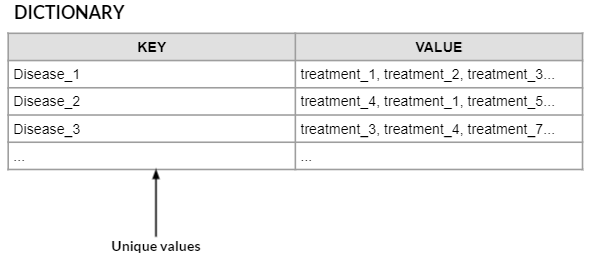

In [26]:
test_pred_labels = [' '.join(label) for label in Y_pred] 
d2t = getDTFromSentence(test_sentences, test_pred_labels)

print("List of unique disesases and treatments")
len(d2t), list(d2t)[:5]

14, 17, DDD                 , gestational diabetes cases
ADJ NOUN NOUN
18, 21, TTT                 , good glycemic control
ADJ ADJ NOUN
17, 19, DD                  , hereditary retinoblastoma
ADJ NOUN
24, 25, T                   , radiotherapy
NOUN
 9, 10, D                   , epilepsy
NOUN
 2,  3, T                   , Methylphenidate
PROPN
27, 33, DDDDDD              , unstable angina or non-Q-wave myocardial infarction
NOUN NOUN ADP NUM NOUN ADP
 5,  6, T                   , roxithromycin
PROPN
18, 20, DD                  , coronary-artery disease
ADJ PUNCT
 2,  4, TT                  , Antichlamydial antibiotics
ADJ NOUN
33, 35, DD                  , pressure pain
NOUN NOUN
64, 66, TT                  , cervical spine
ADJ NOUN
22, 28, DDDDDD              , primary pulmonary hypertension ( PPH )
ADJ ADJ NOUN PUNCT PROPN PUNCT
15, 16, T                   , fenfluramines
NOUN
29, 31, DD                  , essential hypertension
PUNCT NOUN
 4,  5, T                   , moxonidine
NOUN

(140,
 ['gestational diabetes cases',
  'hereditary retinoblastoma',
  'epilepsy',
  'unstable angina or non-Q-wave myocardial infarction',
  'coronary-artery disease'])

In [27]:
d2t['epilepsy']

'Methylphenidate'

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [28]:
# Let us get the treatment for the disease 'hereditary retinoblastoma'
d2t['hereditary retinoblastoma']

'radiotherapy'

So **radiotherapy** is the treatment for the disease **hereditary retinoblastoma**